# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [24]:
import numpy as np
from scipy.stats import norm, multivariate_normal

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

## Gaussian Mixture Model

In [75]:
class GaussianMixtureModel:
  def __init__(self, K, max_epochs=10):
    self.K = K
    self.max_epochs = max_epochs

  def fit(self, X):
    N, D = X.shape
    
    # Kmeans
    kmeans = KMeans(n_clusters=self.K, random_state=42, n_init="auto").fit(X)

    # Dirichlet
    alphas = np.ones(self.K)                    # Priors de Dirichlet
    
    # Normal Inverse Wishart (NIW)
    mu = np.mean(X, axis=0)                     # Média inicial
    kappa = 0.01                                # Peso da média
    nu = D + 2                                  # Graus de liberdade
    S0 = np.cov(X.T) * (1 / self.K ** (2 / D))  # Covariância inicial
    
    # 
    means = kmeans.cluster_centers_
    weights = np.ones(self.K) / self.K
    covariances = np.array([np.eye(D) * 1 / self.K ** (2 / N)] * self.K) # Tava no slide

    # EM
    for _ in range(self.max_epochs):
      # Expectation: calcular responsabilidades
      responsibilities = np.empty((N, self.K))
      
      for k in range(self.K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
          
      # Normalizar responsabilidades
      responsibilities /= responsibilities.sum(axis=1, keepdims=True)

      # M-Step: atualizar parâmetros
      responsibilities_sum = responsibilities.sum(axis=0)

      # Atualizar pesos (π)
      weights = (alphas - 1 + responsibilities_sum) / (N + np.sum(alphas) - self.K)

      # Atualizar médias
      for k in range(self.K):
          weighted_sum = np.sum(responsibilities[:, k][:, np.newaxis] * X, axis=0)
          means[k] = (kappa * mu + weighted_sum) / (kappa + responsibilities_sum[k])

      # Atualizar covariâncias
      for k in range(self.K):
          diff = X - means[k]
          weighted_cov = np.einsum("ni,nj->ij", responsibilities[:, k][:, np.newaxis] * diff, diff) #
          covariances[k] = (S0 + weighted_cov) / (responsibilities_sum[k] + nu + D + 2)
      
      #
      self.weights = weights  
      self.means = means
      self.covariances = covariances
    
  def predict(self, X):
    # Hard cluster
    return np.argmax(self.predict_proba(X), axis=1)
    
  def predict_proba(self, X):
    N = X.shape[0]

    # Responsibility of x_i
    responsibilities = np.empty((N, self.K))
    for k in range(self.K):
      responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])

    return responsibilities   

  def __str__(self):
      return f"GaussianMixtureModel: \n(K → {self.K})"


#### Carregamento dos dados

In [76]:
# Data
X = np.genfromtxt('./files/clustering_data.csv', delimiter=',')
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) # Normalization 0 ~ 1

In [77]:
gmm = GaussianMixtureModel(6)
gmm.fit(X)

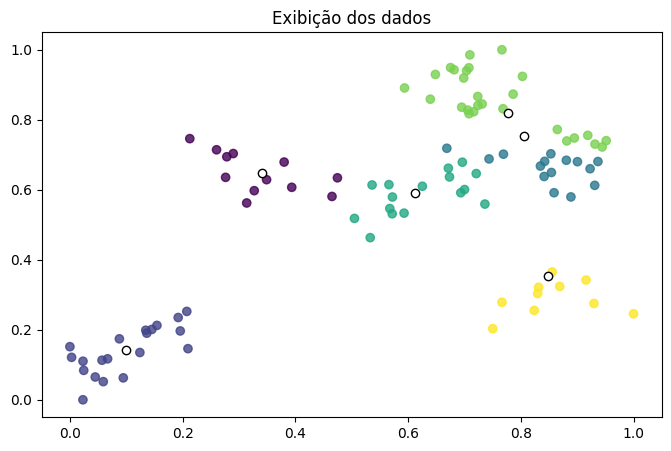

In [86]:
plt.figure(figsize=(8,5))

plt.scatter(X[:,0],X[:,1], c=gmm.predict(X), alpha=0.8)
plt.scatter(gmm.means[:,0], gmm.means[:,1], color='white', edgecolors='black')
# sns.kdeplot(x=X[:, 0], y=X[:, 1], color='k', alpha=0.2)

plt.grid(False)
# plt.axis('off')
plt.title('Exibição dos dados')
plt.show()